<a href="https://colab.research.google.com/github/arashash/boolean-network-optimizer/blob/main/RBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown Visualization Setup
%%capture
import matplotlib.pyplot as plt
# uncomment for getting publication quality plots
# !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
# !pip install SciencePlots
# plt.style.use(['science', 'dark_background'])
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
#@markdown Imports
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from itertools import product
from graphviz import Digraph

dev = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
# Topological variables
in_nodes = 6 # number of input nodes -> M
out_nodes = 6 # number of output nodes -> N
edges = 12 # number of inputs to each output node -> P
total_nodes = out_nodes + in_nodes

In [4]:
# helper constant for binary to decimal conversion
bin_converter = 2**torch.arange(edges).long().to(dev)

In [5]:
# Network parameters
perms = [torch.randperm(total_nodes).view(1, -1) for _ in range(out_nodes)]
conectivity = torch.cat(perms)[:, :edges].to(dev)
# Note: stay tuned here for a batch mode of torch.randperm to avoid looping
# https://github.com/pytorch/pytorch/issues/42502
weights = (torch.rand(2**edges, out_nodes) > 0.5).to(dev)

In [6]:
num_samples = 500 # number of training examples
num_steps = 100 # number of time steps
outputs = torch.zeros(num_steps, out_nodes).bool().to(dev)
code = (torch.rand(out_nodes) > 0.5).to(dev)
errors = []
for i in range(num_samples):
  input = (torch.rand(in_nodes) > 0.5).to(dev) # input -> x
  target = input ^ code # encoding the input
  out = torch.zeros(out_nodes).bool().to(dev) # output nodes are init to zero
  for i in range(num_steps):
    state = torch.cat([input, out]) # state -> s
    node_inputs = state[conectivity] # node_inputs -> I
    indeces = node_inputs.long() @ bin_converter # indeces -> m
    # NOTE: integer matrix multiplcation is not implemnted on GPU yet!
    # folow this issue: https://github.com/pytorch/pytorch/issues/44428

    out = torch.diagonal((weights[indeces])) # out -> y_hat
    outputs[i] = out
    if i == num_steps//2:
      test_outs = outputs[:i]
      pred = torch.sum(test_outs, axis=0) > len(test_outs)//2
      errors += [torch.sum(pred ^ target)]

    if i > num_steps//2: # Training
      error = out ^ target # error -> e
      # comment this out if you want to update anti-diagonals too
      error = error*torch.eye(out_nodes).bool().to(dev) 
      weights[indeces] = weights[indeces] ^ error 

# Visualizations

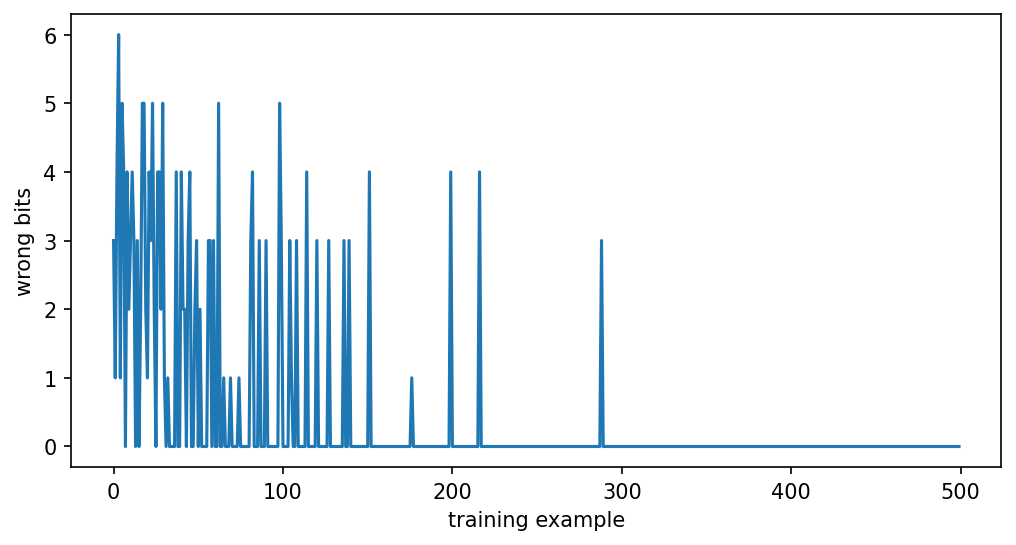

In [7]:
#@markdown Training plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.plot(errors)
plt.ylabel('wrong bits')
plt.xlabel('training example')
plt.savefig('training.png')

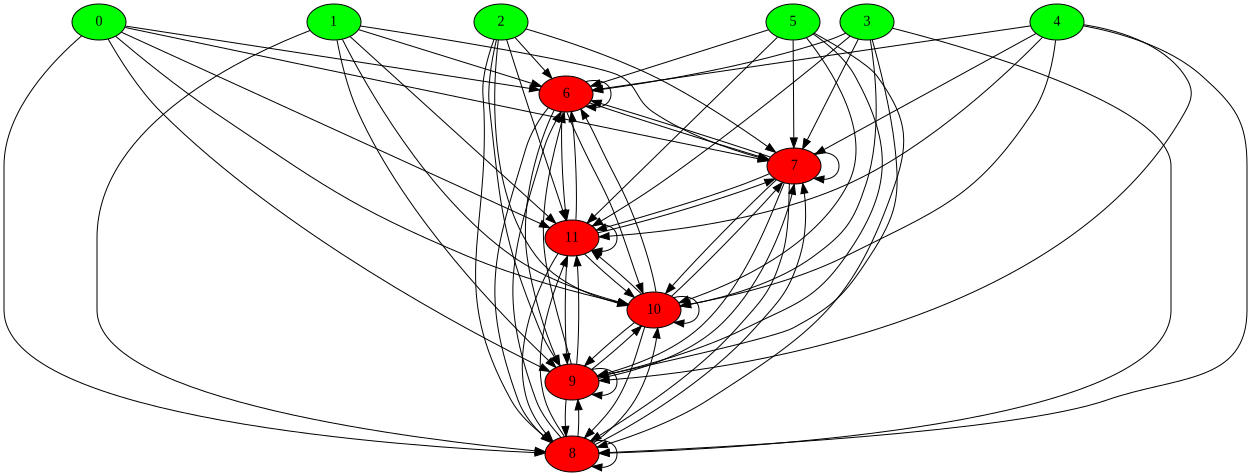

In [8]:
#@markdown Visualization of Graph
dot = Digraph(format='svg')
# dot.attr(rankdir='LR')
dot.attr(bgcolor='transparent')

for m in range(in_nodes):
  dot.node(str(m), str(m), style='filled', fillcolor='green')

for n in range(out_nodes):
  dot.node(str(in_nodes+n), str(in_nodes+n), style='filled', fillcolor='red')

connections = []
for n, inputs in enumerate(conectivity.cpu().numpy()):
  for input in inputs:
    dot.edge(str(input), str(in_nodes+n))

dot.render('network', view=True)
dot

In [9]:
#@markdown Rastor Plot
state_times = outputs.T.cpu().numpy()*np.arange(1, num_steps+1)
colorCodes = np.random.rand(out_nodes, 3)
lineSize = np.linspace(0.4, 0.9, out_nodes)

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.set(xlim=(0, num_steps), ylim=(-0.4, out_nodes))
ax.yaxis.set_ticklabels([])
ims = []
for i in range(num_steps):
    ims.append(ax.eventplot(state_times[:, :i], color=colorCodes,
                            linelengths = lineSize))

im_ani = animation.ArtistAnimation(fig, ims, interval=200,
                                   repeat_delay=1000, blit=True)
# To save this second animation with some metadata, use the following command:
im_ani.save('im.mp4', metadata={'artist':'Arash'})
plt.close()
im_ani